In [1]:
import numpy as np
from dynesty import NestedSampler
from dynesty import utils as dyfunc
import matplotlib.pyplot as plt
import corner

In [7]:

# -------------------------------
# Eggbox definition
# -------------------------------

# Prior bounds
prior_min, prior_max = 0.0, 10.0 * np.pi
prior_volume = (prior_max - prior_min) ** 2  # for reference

# True evidence from the literature
true_logz = 235.856


def loglikelihood(theta):
    """
    Eggbox log-likelihood.
    theta: array of shape (2,)
    """
    x, y = theta
    return (2.0 + np.cos(x / 2.0) * np.cos(y / 2.0)) ** 5


def prior_transform(u):
    """
    Transform from unit cube [0,1]^2 to parameter space [0, 10π]^2.
    """
    x = prior_min + (prior_max - prior_min) * u[0]
    y = prior_min + (prior_max - prior_min) * u[1]
    return np.array([x, y])


# -------------------------------
# Run dynesty Nested Sampling
# -------------------------------

# 2 parameters
ndim = 2

# Set up the sampler
sampler = NestedSampler(
    loglikelihood,
    prior_transform,
    ndim,
    nlive=1000,       # number of live points; increase for accuracy
    sample="rwalk",  # random-walk proposals; can try "unif", "slice"
    bound="multi",   # bounding method ("multi" good for multimodal)
)

print("Running dynesty Nested Sampling on Eggbox...")
sampler.run_nested(print_progress=True)
res = sampler.results
samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)
# -------------------------------
# Report results
# -------------------------------
logZ, logZerr = res.logz[-1], res.logzerr[-1]

print("\n==== RESULTS ====")
print(f"dynesty estimated logZ = {logZ:.3f} ± {logZerr:.3f}")
print(f"True logZ (literature) = {true_logz:.3f}")
print(f"Error = {logZ - true_logz:.3f}")


Running dynesty Nested Sampling on Eggbox...


7410it [00:06, 1068.17it/s, +1000 | bound: 26 | nc: 1 | ncall: 120031 | eff(%):  7.065 | loglstar:   -inf < 242.999 <    inf | logz: 235.831 +/-  0.078 | dlogz:  0.001 >  1.009]


==== RESULTS ====
dynesty estimated logZ = 235.831 ± 0.194
True logZ (literature) = 235.856
Error = -0.025


In [3]:
import morphZ
# Prior bounds
prior_min, prior_max = 0.0, 10.0 * np.pi
prior_volume = (prior_max - prior_min) ** 2  # 2-D uniform cube

def logprior(theta):
    """Uniform prior over [0, 10π]^2."""
    x, y = theta
    if (prior_min <= x <= prior_max) and (prior_min <= y <= prior_max):
        return -np.log(prior_volume)
    else:
        return -np.inf
    
def lnprobfn(theta):
    """Log-probability combining prior and likelihood."""
    return logprior(theta) + loglikelihood(theta)

In [4]:
samples = posterior_samples[::3,:]  # total_samples[::20,:]
tot_len , ndim = samples.shape
print('Total samples:', tot_len, 'Dimensions:', ndim)
log_prob = np.zeros(tot_len)

for i in range(tot_len):
    log_prob[i] = lnprobfn(samples[i,:])

log_p_estimate = morphZ.evidence(
samples,
log_prob,
lnprobfn,
n_resamples=2000,
thin=1,n_estimations=4,morph_type="pair",kde_bw="cv_iso",output_path='./morphZ_eggbox/',top_k_greedy=2)
print('True:', true_logz)

Total samples: 2794 Dimensions: 2

Using Morph_Pairwise for proposal distribution.
MI file not found at ./morphZ_eggbox//params_MI.json. Running dependency tree computation...

Top 10 MI pairs:
  param_0 — param_1 : 0.263168
All MI pairs saved to morphZ_eggbox/params_MI.json
BW file not found at ./morphZ_eggbox//bw_cv_iso_2D.json. Running Bw with cv_iso...
Bandwidths saved to ./morphZ_eggbox/bw_cv_iso_2D.json
Processed 1 groups and 0 single parameters

Estimation 1/4
Evaluating target distribution: 2000/2000
Filtered proposal samples: 1639 valid samples out of 2000 total samples.
 iteration: 3 log(z) old: 236.10580722443498 log(z) New: 236.10580616721793
Converged in 3 iterations. log(z): 236.1058 +/-: 0.0687
Estimation 2/4
Evaluating target distribution: 2000/2000
Filtered proposal samples: 1614 valid samples out of 2000 total samples.
 iteration: 3 log(z) old: 236.11276335413257 log(z) New: 236.11278040096247
Converged in 3 iterations. log(z): 236.1128 +/-: 0.0684
Estimation 3/4
Eval

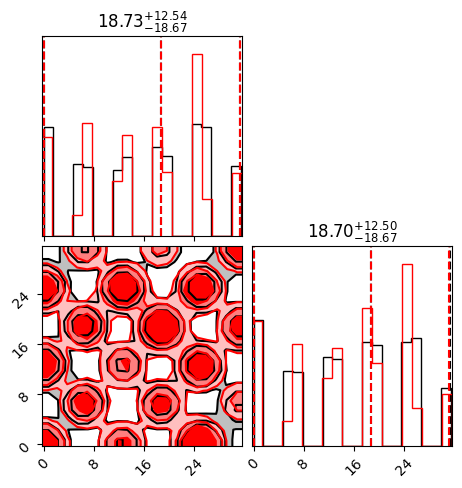

In [5]:
pair_kde = morphZ.PairwiseKDE(samples,'./morphZ_eggbox/params_MI.json',kde_bw=0.01)
pair_samples = pair_kde.resample(2000)
fig = corner.corner(
    posterior_samples[::2,:], bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
corner.corner(
    pair_samples,color="red", bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fig=fig,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
plt.show()